## Predicting short term price movements of BTCUSD using trade flow, order flow, and volume imbalance

References and inspiration
 * https://pdfs.semanticscholar.org/cf7e/9d9960be215cbc5a0b9f39d4c50879568be3.pdf
 * https://medium.com/@eliquinox/order-flow-analysis-of-cryptocurrency-markets-b479a0216ad8

Orderbook and trade data collected from Coinbase API using the script in this repo. Trade, order, and volume imbalance are calculated and stored in a database.

Features
* Order Imbalance Ratio
    * A quantification of buy orders vs sell orders in an orderbook at a given time weighted by orderbook level
* Trade Flow Imbalance
    * Ratio of market buys to market sells over a period of time
* Volume Order Imbalance
    * A quantification of buy orders vs sell orders in an orderbook

Targets
* Lag midprice change
    * Change in midprice from start of lag period to end of lag period
* Forecast midprice change
    * Change in midprice from end of lag period to a time in the future

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import certifi
import sqlite3

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import SVR, SVC
from sklearn.dummy import DummyClassifier

from scipy import stats
from scipy.stats.mstats import winsorize

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.gofplots import qqplot

In [3]:
# Read data from DB
conn = sqlite3.connect('one_time_now.db')

c = conn.cursor()

data = pd.read_sql_query('SELECT * FROM come_correct' , conn)

## Explore data

Orderbook data and trade data was cleaned before populating the database. Only valid values and expected data types were added.

In [4]:
print(data.shape)
data.head()

(93143, 13)


,lag_TFI,lag_average_OIR,lag_average_VOI,lag_sum_OIR,lag_sum_VOI,lag_average_spread,lag_midprice_change,forecast_10_midprice_change,forecast_30_midprice_change,forecast_60_midprice_change,forecast_300_midprice_change,forecast_600_midprice_change,lag
0,3.302703,-0.964204,-141.990875,-0.964204,-141.990875,0.01,0.0,0.0,-1.0,-4.0250,NaN,1.8000,10
1,3.302703,-0.964204,-141.990875,-1.928408,-283.981751,0.01,0.0,0.0,-1.0,-4.2150,NaN,1.8000,10
2,2.724696,-0.965308,-145.846409,-2.895924,-437.539226,0.01,0.0,0.0,-1.0,-4.2150,NaN,1.7425,10
3,1.777419,-0.965860,-147.774175,-3.863439,-591.096700,0.01,0.0,0.0,-1.0,-4.1875,NaN,1.1350,10
4,0.990323,-0.966668,-152.900272,-4.833340,-764.501359,0.01,0.0,-1.0,-1.0,-4.1600,NaN,0.5850,10


In [5]:
# Check for missing values
data.isna().mean()

lag_TFI                         0.000000
lag_average_OIR                 0.000000
lag_average_VOI                 0.000000
lag_sum_OIR                     0.000000
lag_sum_VOI                     0.000000
lag_average_spread              0.000000
lag_midprice_change             0.000000
forecast_10_midprice_change     0.019808
forecast_30_midprice_change     0.025863
forecast_60_midprice_change     0.029836
forecast_300_midprice_change    0.055817
forecast_600_midprice_change    0.067520
lag                             0.000000
dtype: float64

In [6]:
# Drop NAs
data.info()
data = data.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93143 entries, 0 to 93142
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   lag_TFI                       93143 non-null  float64
 1   lag_average_OIR               93143 non-null  float64
 2   lag_average_VOI               93143 non-null  float64
 3   lag_sum_OIR                   93143 non-null  float64
 4   lag_sum_VOI                   93143 non-null  float64
 5   lag_average_spread            93143 non-null  float64
 6   lag_midprice_change           93143 non-null  float64
 7   forecast_10_midprice_change   91298 non-null  float64
 8   forecast_30_midprice_change   90734 non-null  float64
 9   forecast_60_midprice_change   90364 non-null  float64
 10  forecast_300_midprice_change  87944 non-null  float64
 11  forecast_600_midprice_change  86854 non-null  float64
 12  lag                           93143 non-null  int64  
dtypes

In [62]:
# Create dataframes for each lag period in seconds
lag_10 = data.loc[data['lag']==10].drop(columns=['lag'])
lag_30 = data.loc[data['lag']==30].drop(columns=['lag'])
lag_60 = data.loc[data['lag']==60].drop(columns=['lag'])
lag_300 = data.loc[data['lag']==300].drop(columns=['lag'])
lag_600 = data.loc[data['lag']==600].drop(columns=['lag'])

In [15]:
# Create binary columns for direction of midprice change
for df in [lag_10,lag_30,lag_60,lag_300,lag_600]:
    df['midprice_direction'] = (df['lag_midprice_change'] > 0).astype(int)
    for col in ['forecast_10_midprice_change', 'forecast_30_midprice_change', 'forecast_60_midprice_change', 'forecast_300_midprice_change', 'forecast_600_midprice_change']:
        df[col+'_midprice_direction'] = (df[col] > 0).astype(int)


First we'll investigate the relationship between TFI, OIR, VOI and the change in midprice between the start of the lag period and the end of the period.

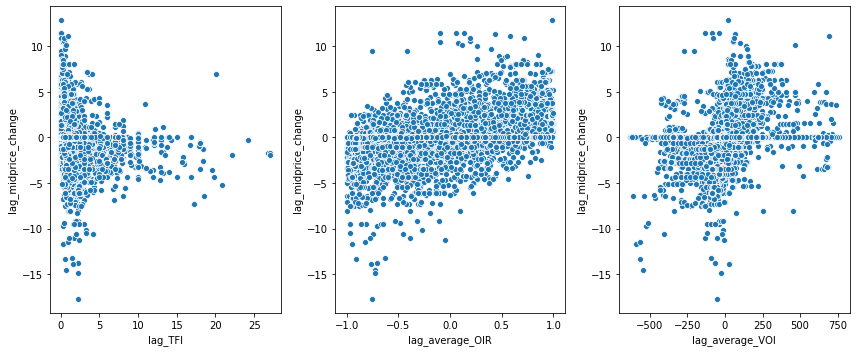

In [8]:
# Plot TFI, OIR, and VOI against midprice_change for lag_10
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.scatterplot(x= 'lag_TFI', y= 'lag_midprice_change', data = lag_10, ax = axes[0])
sns.scatterplot(x= 'lag_average_OIR', y = 'lag_midprice_change', data = lag_10, ax = axes[1])
sns.scatterplot(x= 'lag_average_VOI', y = 'lag_midprice_change', data = lag_10, ax = axes[2])
axes[0].set_xlabel('lag_TFI')
axes[1].set_xlabel('lag_average_OIR')
axes[2].set_xlabel('lag_average_VOI')
plt.tight_layout()
plt.show()

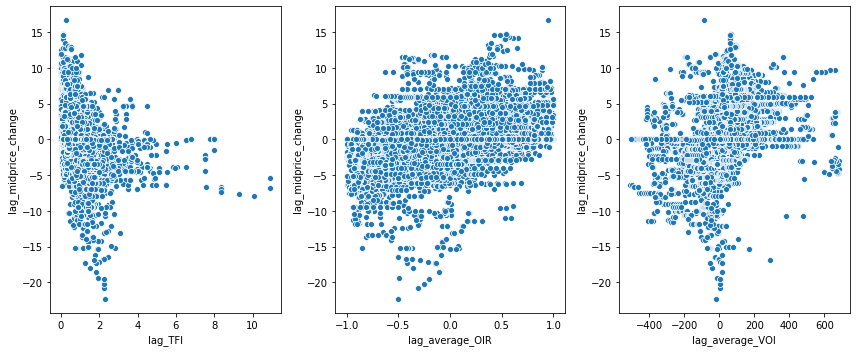

In [9]:
# Plot TFI, OIR, and VOI against midprice_change for lag_30
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.scatterplot(x= 'lag_TFI', y= 'lag_midprice_change', data = lag_30, ax = axes[0])
sns.scatterplot(x= 'lag_average_OIR', y = 'lag_midprice_change', data = lag_30, ax = axes[1])
sns.scatterplot(x= 'lag_average_VOI', y = 'lag_midprice_change', data = lag_30, ax = axes[2])
axes[0].set_xlabel('lag_TFI')
axes[1].set_xlabel('lag_average_OIR')
axes[2].set_xlabel('lag_average_VOI')
plt.tight_layout()
plt.show()

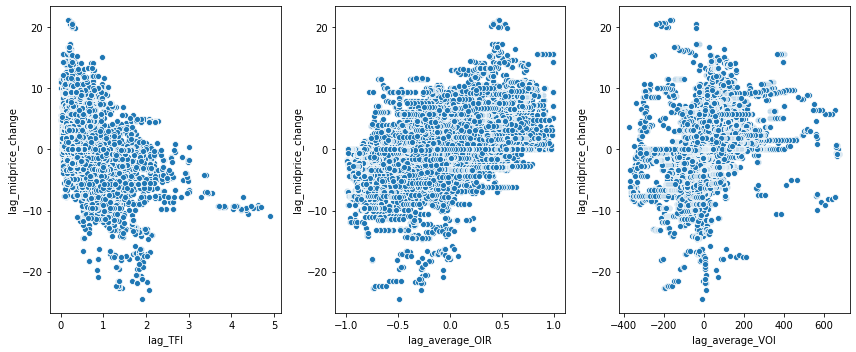

In [10]:
# Plot TFI, OIR, and VOI against midprice_change for lag_60
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.scatterplot(x= 'lag_TFI', y= 'lag_midprice_change', data = lag_60, ax = axes[0])
sns.scatterplot(x= 'lag_average_OIR', y = 'lag_midprice_change', data = lag_60, ax = axes[1])
sns.scatterplot(x= 'lag_average_VOI', y = 'lag_midprice_change', data = lag_60, ax = axes[2])
axes[0].set_xlabel('lag_TFI')
axes[1].set_xlabel('lag_average_OIR')
axes[2].set_xlabel('lag_average_VOI')
plt.tight_layout()
plt.show()

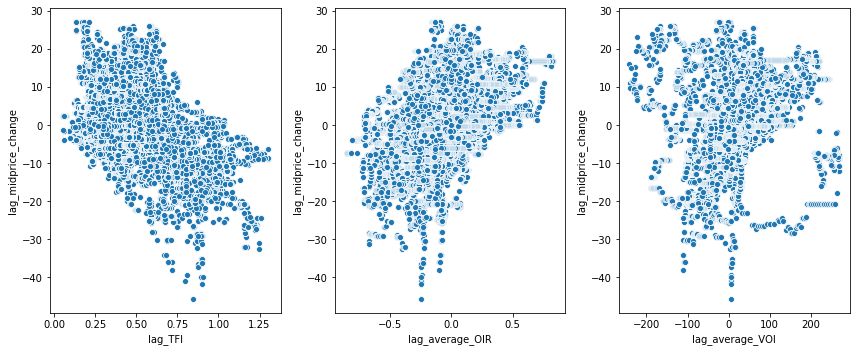

In [11]:
# Plot TFI, OIR, and VOI against midprice_change for lag_300
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.scatterplot(x= 'lag_TFI', y= 'lag_midprice_change', data = lag_300, ax = axes[0])
sns.scatterplot(x= 'lag_average_OIR', y = 'lag_midprice_change', data = lag_300, ax = axes[1])
sns.scatterplot(x= 'lag_average_VOI', y = 'lag_midprice_change', data = lag_300, ax = axes[2])
axes[0].set_xlabel('lag_TFI')
axes[1].set_xlabel('lag_average_OIR')
axes[2].set_xlabel('lag_average_VOI')
plt.tight_layout()
plt.show()

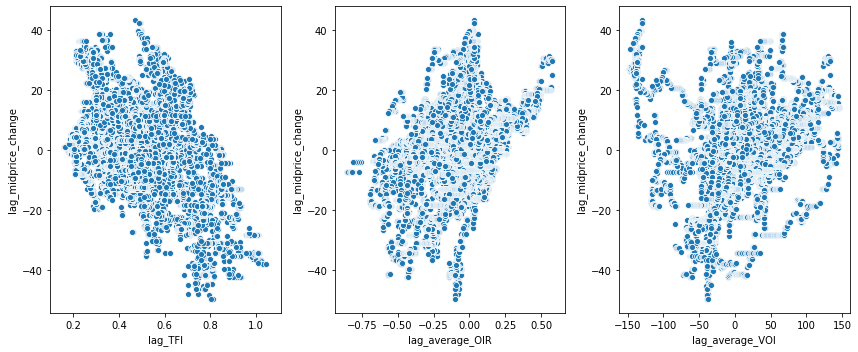

In [12]:
# Plot TFI, OIR, and VOI against midprice_change for lag_600
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.scatterplot(x= 'lag_TFI', y= 'lag_midprice_change', data = lag_600, ax = axes[0])
sns.scatterplot(x= 'lag_average_OIR', y = 'lag_midprice_change', data = lag_600, ax = axes[1])
sns.scatterplot(x= 'lag_average_VOI', y = 'lag_midprice_change', data = lag_600, ax = axes[2])
axes[0].set_xlabel('lag_TFI')
axes[1].set_xlabel('lag_average_OIR')
axes[2].set_xlabel('lag_average_VOI')
plt.tight_layout()
plt.show()

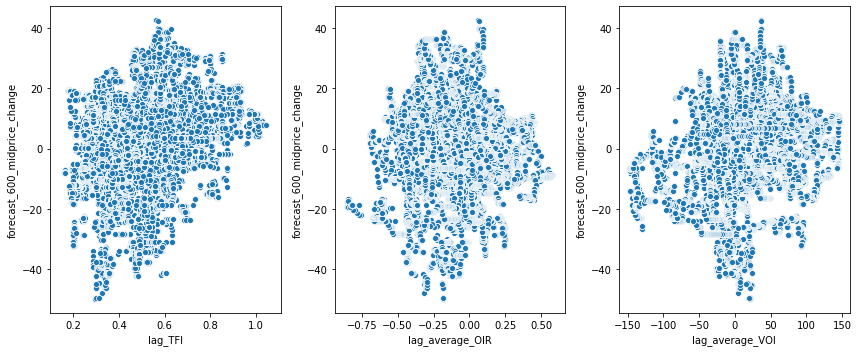

In [17]:
# Plot TFI, OIR, and VOI against forecast_600_midprice_change for lag_600
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.scatterplot(x= 'lag_TFI', y= 'forecast_600_midprice_change', data = lag_600, ax = axes[0])
sns.scatterplot(x= 'lag_average_OIR', y = 'forecast_600_midprice_change', data = lag_600, ax = axes[1])
sns.scatterplot(x= 'lag_average_VOI', y = 'forecast_600_midprice_change', data = lag_600, ax = axes[2])
axes[0].set_xlabel('lag_TFI')
axes[1].set_xlabel('lag_average_OIR')
axes[2].set_xlabel('lag_average_VOI')
plt.tight_layout()
plt.show()

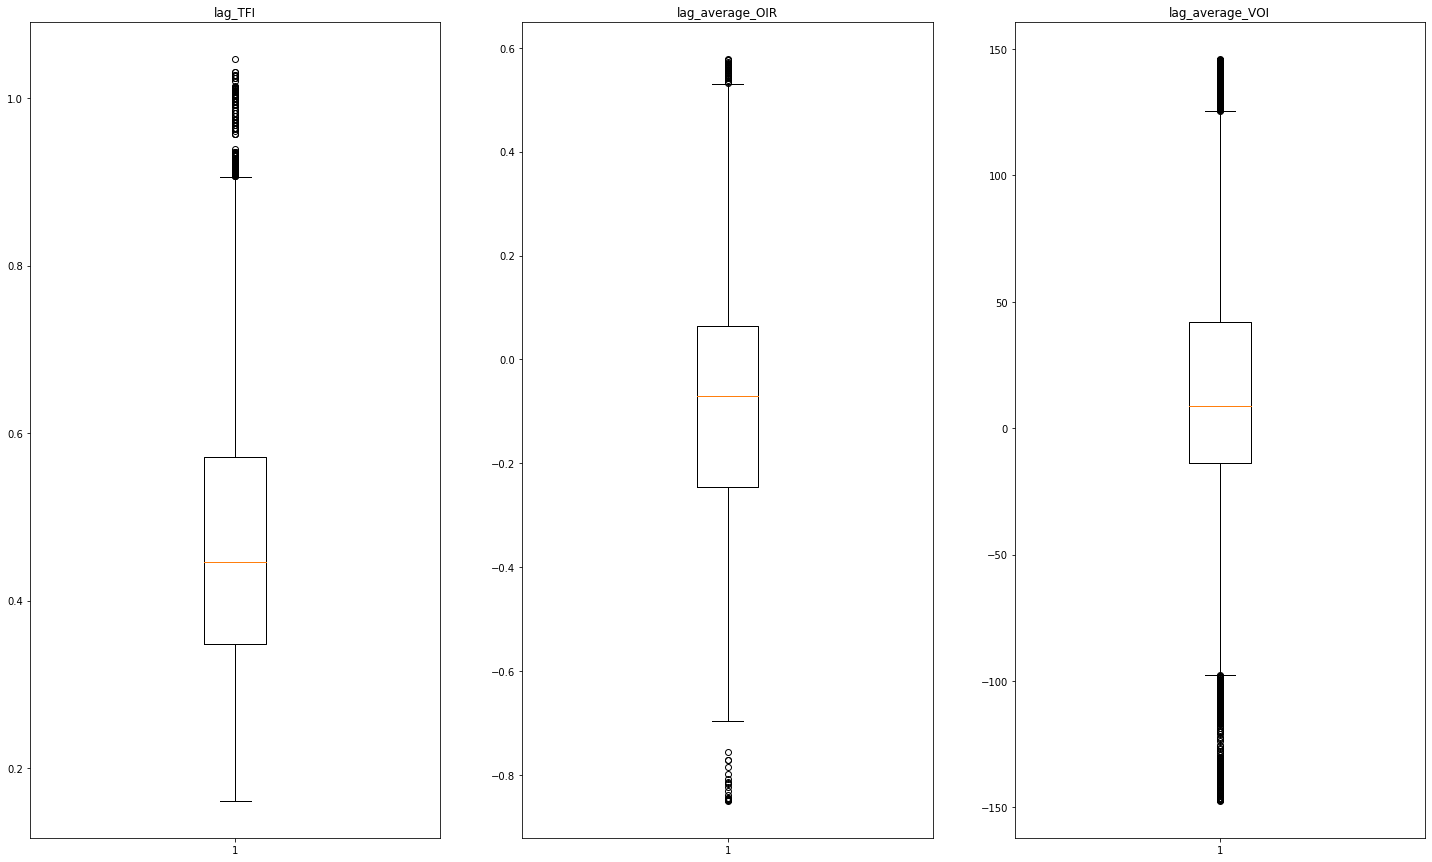

In [47]:
# Visualize outliers
cols = ['lag_TFI','lag_average_OIR','lag_average_VOI']
count = 1
plt.figure(figsize=(25, 15))
for elem in cols:
    plt.subplot(len(cols) / 3, len(cols) / 1, count)
    plt.boxplot(lag_600[elem])
    plt.title(elem)
    count += 1

plt.show()

In [63]:
# Convert lag_TFI to the natural log of lag_TFI and windsorize average_VOI
for df in [lag_10,lag_30,lag_60,lag_300,lag_600]:
    df['lag_average_VOI'] = winsorize(df['lag_average_VOI'], (0.02,0.02))
    df['lag_TFI'] = np.log(df['lag_TFI']) 

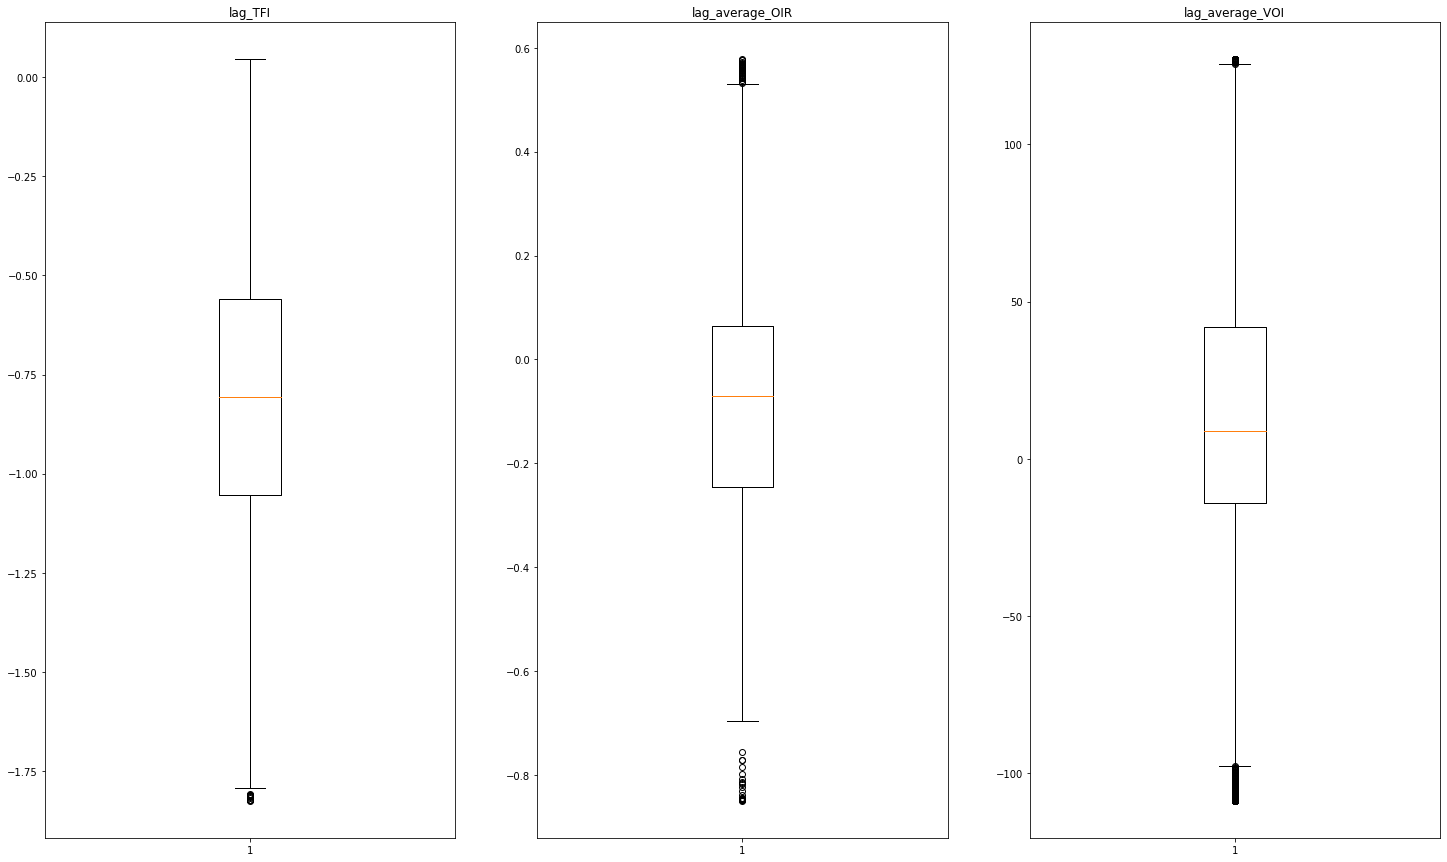

In [64]:
# Visualize outliers
cols = ['lag_TFI','lag_average_OIR','lag_average_VOI']
count = 1
plt.figure(figsize=(25, 15))
for elem in cols:
    plt.subplot(len(cols) / 3, len(cols) / 1, count)
    plt.boxplot(lag_600[elem])
    plt.title(elem)
    count += 1

plt.show()

In [65]:
# Variance inflation factor to check for multicollinearity
vifs = []
for i in range(lag_600[['lag_TFI','lag_average_OIR','lag_average_VOI']].shape[1]):
    vif = variance_inflation_factor(lag_600[['lag_TFI','lag_average_OIR','lag_average_VOI']].values, i)
    vifs.append(vif)
pd.Series(vifs, index=lag_600[['lag_TFI','lag_average_OIR','lag_average_VOI']].columns)

lag_TFI            1.478501
lag_average_OIR    1.703885
lag_average_VOI    1.873887
dtype: float64

##### Observations

As the time period increases, the linear relationship between OIR and TFI becomes more obvious and there is more linearity between VOI and midprice change at lower lag periods.

The relationship is not as linear when comparing the features with forecast period price changes.

## Model Testing

Lag periods of 300 and 600 seconds had the most accurate test scores compared to the other lag periods. We will continue with only those two lag periods. Forecast periods of 60, 300, 600 had the most accurate scores so we will use those.

After testing multiple models, GradientBoostingRegressor is best for predicting price change. GradientBoostingClassifier is best for predicting the direction of the price change.

### Regression models

##### Gradient Boosted Regressor

In [147]:
for df in [lag_300,lag_600]:
    for i in ['lag_midprice_change', 'forecast_60_midprice_change_midprice_direction', 'forecast_300_midprice_change_midprice_direction', 'forecast_600_midprice_change_midprice_direction']:
        X = df[['lag_TFI','lag_average_OIR','lag_average_VOI']]
        y = df[i]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=11)

        scaler = StandardScaler()

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        X_train = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)
        X_test = pd.DataFrame(X_test, columns=X.columns, index=y_test.index)

        grid = {
            "gbr__subsample": [0.75],
            "gbr__max_features": [1.0],
            "gbr__max_depth": [30,40,50],
        }

        n_trees = 100
        learning_rate = 2 / n_trees

        pipeline = Pipeline([
            ("gbr", GradientBoostingRegressor(n_estimators=n_trees, 
                                              learning_rate=learning_rate))
        ])

        pipeline_cv = GridSearchCV(pipeline, grid, verbose=1)
        pipeline_cv.fit(X_train, y_train)

        train_score = pipeline_cv.score(X_train, y_train)
        test_score = pipeline_cv.score(X_test, y_test)

        print(i)
        print(f"train_score {train_score}")
        print(f"test_score {test_score}")
        print(pipeline_cv.best_params_)
        print('~'*24,'\n')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.1min finished


lag_midprice_change
train_score 0.9795739548673134
test_score 0.8606193836720695
{'gbr__max_depth': 50, 'gbr__max_features': 1.0, 'gbr__subsample': 0.75}
~~~~~~~~~~~~~~~~~~~~~~~~ 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.0min finished


forecast_60_midprice_change_midprice_direction
train_score 0.9741177963905079
test_score 0.6148817723374504
{'gbr__max_depth': 50, 'gbr__max_features': 1.0, 'gbr__subsample': 0.75}
~~~~~~~~~~~~~~~~~~~~~~~~ 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.1min finished


forecast_300_midprice_change_midprice_direction
train_score 0.9768186374021596
test_score 0.7363006114833015
{'gbr__max_depth': 50, 'gbr__max_features': 1.0, 'gbr__subsample': 0.75}
~~~~~~~~~~~~~~~~~~~~~~~~ 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   55.7s finished


forecast_600_midprice_change_midprice_direction
train_score 0.9782183656669281
test_score 0.7926216660859731
{'gbr__max_depth': 40, 'gbr__max_features': 1.0, 'gbr__subsample': 0.75}
~~~~~~~~~~~~~~~~~~~~~~~~ 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.0min finished


lag_midprice_change
train_score 0.9811577713875052
test_score 0.9034869198459732
{'gbr__max_depth': 30, 'gbr__max_features': 1.0, 'gbr__subsample': 0.75}
~~~~~~~~~~~~~~~~~~~~~~~~ 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   59.6s finished


forecast_60_midprice_change_midprice_direction
train_score 0.9761756271597822
test_score 0.6675292611444852
{'gbr__max_depth': 30, 'gbr__max_features': 1.0, 'gbr__subsample': 0.75}
~~~~~~~~~~~~~~~~~~~~~~~~ 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   51.2s finished


forecast_300_midprice_change_midprice_direction
train_score 0.9790605939369457
test_score 0.7987201067627516
{'gbr__max_depth': 50, 'gbr__max_features': 1.0, 'gbr__subsample': 0.75}
~~~~~~~~~~~~~~~~~~~~~~~~ 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   48.1s finished


forecast_600_midprice_change_midprice_direction
train_score 0.9799699114086379
test_score 0.8295541815192092
{'gbr__max_depth': 30, 'gbr__max_features': 1.0, 'gbr__subsample': 0.75}
~~~~~~~~~~~~~~~~~~~~~~~~ 



In [148]:
importance_df = pd.DataFrame()

importance_df["feat"] = X_train.columns
importance_df["importance"] = pipeline_cv.best_estimator_["gbr"].feature_importances_
importance_df

,feat,importance
0,lag_TFI,0.364551
1,lag_average_OIR,0.285998
2,lag_average_VOI,0.349451


In [155]:
y_pred = pipeline_cv.predict(X_test)

evaluators = [
    "Mean Absolute Error",
    "Mean Squared Error",
    "Root Mean Square Error",
]
evaluations = [
    mean_absolute_error(y_test, y_pred),
    mse(y_test, y_pred),
    rmse(y_test, y_pred),
]
evaluation_df = pd.DataFrame({"Evaluator": evaluators, "Error": evaluations})
evaluation_df

,Evaluator,Error
0,Mean Absolute Error,0.126083
1,Mean Squared Error,0.042317
2,Root Mean Square Error,0.205712


In [156]:
# Linear Regression
model = LinearRegression()
model.fit(X_train,y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(train_score)
print(test_score)

0.07823796738390154
0.07302546711069124


### Classification

Predict the direction of the midprice change

In [145]:
lag_600

,lag_TFI,lag_average_OIR,lag_average_VOI,lag_sum_OIR,lag_sum_VOI,lag_average_spread,lag_midprice_change,forecast_10_midprice_change,forecast_30_midprice_change,forecast_60_midprice_change,...,forecast_10_midprice_changemidprice_direction,forecast_30_midprice_changemidprice_direction,forecast_60_midprice_changemidprice_direction,forecast_300_midprice_changemidprice_direction,forecast_600_midprice_changemidprice_direction,forecast_10_midprice_change_midprice_direction,forecast_30_midprice_change_midprice_direction,forecast_60_midprice_change_midprice_direction,forecast_300_midprice_change_midprice_direction,forecast_600_midprice_change_midprice_direction
72022,0.673395,-0.543582,-22.331471,-117.957203,-4845.929187,0.728664,-2.420,4.2200,3.3200,-1.1900,...,1,1,0,1,1,1,1,0,1,1
72023,0.672619,-0.540802,-22.243420,-117.894762,-4849.065476,0.725367,-1.575,3.3750,2.9100,-2.0350,...,1,1,0,0,1,1,1,0,0,1
72024,0.672619,-0.541872,-22.228985,-118.669904,-4868.147663,0.726164,-1.575,3.3175,2.6125,-1.6050,...,1,1,0,0,1,1,1,0,0,1
72025,0.667167,-0.542932,-22.214681,-119.445046,-4887.229849,0.726955,0.975,0.1600,-0.2350,-4.1550,...,1,0,0,0,1,1,0,0,0,1
72026,0.642511,-0.538789,-22.155439,-119.072319,-4896.352035,0.728462,1.245,-0.5625,-0.2875,-4.5325,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92747,0.620737,0.082930,2.447893,38.147707,1126.030552,0.069717,9.660,0.0000,-2.9200,-6.8000,...,0,0,0,0,0,0,0,0,0,0
92748,0.622387,0.080691,2.369944,37.198740,1092.544317,0.069588,9.190,0.4700,-2.4500,-6.3300,...,1,0,0,0,0,1,0,0,0,0
92749,0.624386,0.080431,2.322914,37.078527,1070.863525,0.069588,9.650,0.0000,-2.9200,-6.8000,...,0,0,0,0,0,0,0,0,0,0
92750,0.627390,0.077181,2.024248,35.503152,931.154272,0.069717,9.650,-1.4300,-5.4700,-6.8000,...,0,0,0,0,0,0,0,0,0,0


#### Gradient Boosting Classifier

In [158]:
for df in [lag_300,lag_600]:
    for i in ['forecast_60_midprice_change_midprice_direction', 'forecast_300_midprice_change_midprice_direction', 'forecast_600_midprice_change_midprice_direction']:
        X = df[['lag_TFI','lag_average_OIR','lag_average_VOI']]
        y = df[i]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=11)

        scaler = StandardScaler()

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        X_train = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)
        X_test = pd.DataFrame(X_test, columns=X.columns, index=y_test.index)

        grid = {
            "gbc__subsample": [1.0],
            "gbc__max_features": [0.25, 0.5, 1.0],
            "gbc__max_depth": [10, 20, 30],
        }

        n_trees = 100
        learning_rate = 2 / n_trees

        pipeline = Pipeline([
            ("gbc", GradientBoostingClassifier(n_estimators=n_trees, 
                                              learning_rate=learning_rate))
        ])

        pipeline_cv = GridSearchCV(pipeline, grid, verbose=1)
        pipeline_cv.fit(X_train, y_train)

        train_score = pipeline_cv.score(X_train, y_train)
        test_score = pipeline_cv.score(X_test, y_test)
    
        print(i)
        print(f"train_score {train_score}")
        print(f"test_score {test_score}")

        pipeline_cv.best_params_

        y_pred = pipeline_cv.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(
        cm, 
        index=['actual_0', 'actual_1'], 
        columns=['pred_0', 'pred_1']
    )
        display(cm_df)
        print(pipeline_cv.best_params_)
        print('~'*24,'\n')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 13.1min finished


forecast_60_midprice_change_midprice_direction
train_score 1.0
test_score 0.874413469500414


,pred_0,pred_1
actual_0,1797,183
actual_1,272,1371


{'gbc__max_depth': 30, 'gbc__max_features': 0.5, 'gbc__subsample': 1.0}
~~~~~~~~~~~~~~~~~~~~~~~~ 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 13.2min finished


forecast_300_midprice_change_midprice_direction
train_score 1.0
test_score 0.9177477228815898


,pred_0,pred_1
actual_0,1646,147
actual_1,151,1679


{'gbc__max_depth': 30, 'gbc__max_features': 0.25, 'gbc__subsample': 1.0}
~~~~~~~~~~~~~~~~~~~~~~~~ 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 41.6min finished


forecast_600_midprice_change_midprice_direction
train_score 1.0
test_score 0.9414849572177754


,pred_0,pred_1
actual_0,1550,107
actual_1,105,1861


{'gbc__max_depth': 30, 'gbc__max_features': 0.5, 'gbc__subsample': 1.0}
~~~~~~~~~~~~~~~~~~~~~~~~ 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 18.6min finished


forecast_60_midprice_change_midprice_direction
train_score 1.0
test_score 0.9006348330113166


,pred_0,pred_1
actual_0,1843,137
actual_1,223,1420


{'gbc__max_depth': 30, 'gbc__max_features': 0.5, 'gbc__subsample': 1.0}
~~~~~~~~~~~~~~~~~~~~~~~~ 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 10.3min finished


forecast_300_midprice_change_midprice_direction
train_score 1.0
test_score 0.9478332873309412


,pred_0,pred_1
actual_0,1721,79
actual_1,110,1713


{'gbc__max_depth': 30, 'gbc__max_features': 0.5, 'gbc__subsample': 1.0}
~~~~~~~~~~~~~~~~~~~~~~~~ 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  8.2min finished


forecast_600_midprice_change_midprice_direction
train_score 1.0
test_score 0.9608059619100193


,pred_0,pred_1
actual_0,1606,55
actual_1,87,1875


{'gbc__max_depth': 20, 'gbc__max_features': 0.25, 'gbc__subsample': 1.0}
~~~~~~~~~~~~~~~~~~~~~~~~ 



A forecast of 600 seconds yeilds the most accurate results. Let's investigate further.

In [159]:
report = classification_report(
    y_test, y_pred, target_names=["Negative", "Positive"]
)
print(report)

              precision    recall  f1-score   support

    Negative       0.95      0.97      0.96      1661
    Positive       0.97      0.96      0.96      1962

    accuracy                           0.96      3623
   macro avg       0.96      0.96      0.96      3623
weighted avg       0.96      0.96      0.96      3623



In [162]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.5415401600883246

In [163]:
# Logistic Regression
model = LogisticRegression()
model.fit(X_train,y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(train_score)
print(test_score)

0.6220673475020702
0.6268285950869446


### Results

A lag period of of 600 seconds and a forecast of 600 seconds has the best accuracy when predicting price change. The regression model predicted change in midprice of a 600 second forecast with a mean absolute error of ~0.1 USD. The classification model predicts the direction of the midprice change with ~97% accuracy.

Trade flow imbalance, order flow imbalance, and volume order imbalance attempt to quantify the strength of the bid and ask sides of the market over a period of time. If there are more market buys compared to market sells over a period of time, the buyers have more conviction and the price is likely to increase. An orderbook stacked on the sell side could signify a strong intent to sell.

The regression and classification models appear to promising in their predictive power but to really test the usefulness they need to be tested over a larger dataset. Logic needs to applied using these models to develop a trading strategy. Evaluators such as mean absolute error are not the best interpretations of the strength of the models. What really matters is profit vs loss.